In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

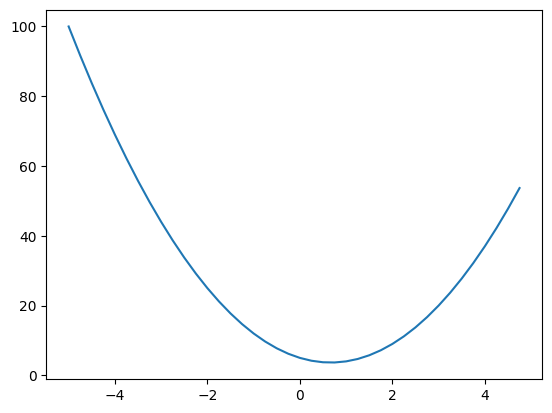

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Now the derivative at a particular point
# from the definition of derivate
h = 0.00000001   # lim h->0
x = 3

f(x+h)  # it should be greater than f(x)

# Now Slope

slope = (f(x+h) - f(x)) / h
slope


14.00000009255109

In [6]:
h = 0.00000001   # lim h->0
x = -3

f(x+h)  # it should be greater than f(x)

# Now Slope

slope = (f(x+h) - f(x)) / h
slope   # here it will be negative

-22.00000039920269

In [7]:
h = 0.00000001   # lim h->0
x = 2/3

f(x+h)  # it should be greater than f(x)

# Now Slope

slope = (f(x+h) - f(x)) / h
slope   # here it will be zero

0.0

In [8]:
# Now more complex function
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c

a += h  # increment a by h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c

b += h  # increment b by h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c

c += h  # increment c by h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Value() Object Building

In [12]:
class Value:

    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"


In [13]:
a = Value(2.0)
a

Value(data=2.0)

In [15]:
# Now we want to add 2 value objects
a = Value(2.0)
b = Value(-3.0)
c = a + b   # This operating is not defined yet
c

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [16]:
class Value:

    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

In [17]:
# Now we want to add 2 value objects
a = Value(2.0)
b = Value(-3.0)
c = a + b   # This operating is not defined yet
c

# a +b 
# python will do
# a.__add__(b)

Value(data=-1.0)

In [18]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b +c  # (a.__mul__(b)).__add__(c)
d

Value(data=4.0)

In [19]:
# We want to keep a track of relationship between a, b, c, d
d._prev # we know the children of the value

{Value(data=-6.0), Value(data=10.0)}

In [20]:
# Now we also want to know what operations created them
d._op

'+'

##### These expressions will get very large, we would like to visualise them with this code

In [21]:
#!pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [22]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0     # grad represents the derrivative of output (say L) wrt to value (say a or f)
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

In [23]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e+c; d.label="d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"
L

Value(data=-8.0)

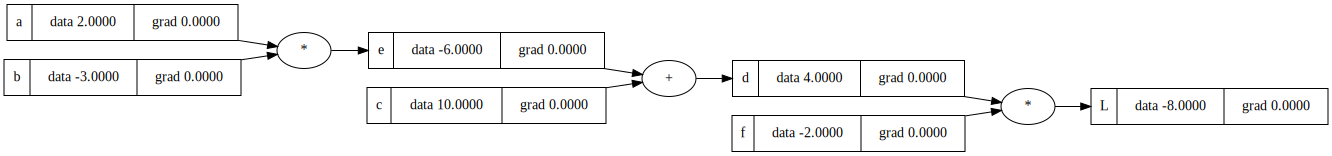

In [24]:
# using this we can visulize the operations
draw_dot(L)

##### Now let's calculate gradients

In [26]:
def lol():
    h = 0.0001
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e+c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L"

    L1 = L.data

    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e+c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L"

    L2 = L.data

    print((L2-L1)/h)

lol()

6.000000000021544


In [27]:
L.grad = 1.0